# Example SciDB queries for trade and quote data

This iPython Notebook replicates the work done by AFL queries at [this repo's main page](https://github.com/Paradigm4/TAQ/) in SciDB-py. 

The example queries here use example data obtained from Nyxdata. The example data file format specification is available from: http://www.nyxdata.com/doc/224904

# Loading the data into ScIDB

The `trades_load.sh` and `trades_redim.sh` scripts load the `EQY_US_ALL_TRADE_20131218.zip` data and redimension them into a `ms` (time) by `symbol_index` 2-d SciDB array. The script also creates an auxiliary mapping array named `tkr` between string ticker symbol and integer symbol index.

The `quotes_load.sh` and `quotes_redim.sh` script does the same thing but for the `EQY_US_ALL_NBBO` quote data file.

Run the following to load and redimension the example data

In [ ]:
import subprocess
subprocess.call(["./trades_load.sh"])
subprocess.call("./trades_redim.sh")


In [ ]:
subprocess.call(["./quotes_load.sh", "/tmp/EQY_US_ALL_NBBO_20131218.zip",  "1000000"])
subprocess.call("./quotes_redim.sh")

# Connecting to the database

Then let's run some queries on the loaded trades and quote (TAQ) data from the comfort of SciDB-Py.
First let us set up the connectivity to the database (and also import some useful libraries)

In [1]:
import matplotlib.pyplot as plt
from scidbpy import connect
import time
sdb = connect("http://localhost:8080")
afl = sdb.afl

Next, associate Python objects with SciDB arrays (no data transfers yet -- just connections)

In [2]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

An example lookup

In [3]:
trades.limit(5).todataframe() 

price  volume  sequence_number condition exchange
symbol_index tm                                                           
0            34200011  56.5000   32051             2325         O        N
             34201498  56.4100      30             2971         I        N
             34207432  56.4025     100             3782         @        D
             34207506  56.4100     100             3785         @        B
             34210008  56.4800     100             4112         Q        P

# SciDB array object

Let's take a closer look at one of the SciDB array objects

In [4]:
trades

SciDBArray()

In [5]:
trades.schema

u'<price:double,volume:int64,sequence_number:int64,condition:string,exchange:string> [symbol_index=0:*,10,0,tm=0:86399999,86400000,0]'

# Looking up trades by symbol string

Join with the auxiliary `tkr` array to look up data by ticker symbol name. Here are some examples:


In [6]:
symbol = "ABBV"
sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).limit(5).todataframe()


price  volume  sequence_number condition exchange  \
symbol_index tm                                                            
22           31135209  53.09     200             1600        FT        P   
             31135210  53.07     500             1603        FT        P   
             31135237  53.00     100             1605        FT        P   
             31135258  53.63      20             1607        TI        K   
             31135392  53.00     100             1609         T        Z   

                      symbol  
symbol_index tm               
22           31135209   ABBV  
             31135210   ABBV  
             31135237   ABBV  
             31135258   ABBV  
             31135392   ABBV

# Computing VWAP

Let's turn to another common kind of operation, computing volume-weighted average price (VWAP). We'll compute it for every instrument across their raw trade data in the array tades, and store the result into a new array called 'VWAP'.

In [7]:
vwap = trades.apply('pv', 'price*volume')
vwap = sdb.afl.cumulate(vwap, \
                        'sum(pv) as numerator', \
                        'sum(volume) as denominator', 'tm')
vwap = vwap.apply('vwap', 'numerator/denominator')
sdb.merge(vwap, tkr[tkr == 'ABBV']).\
    limit(5).\
    todataframe()

numerator  denominator       vwap symbol
symbol_index tm                                                
22           31135209    10618.0          200  53.090000   ABBV
             31135210    37153.0          700  53.075714   ABBV
             31135237    42453.0          800  53.066250   ABBV
             31135258    43525.6          820  53.080000   ABBV
             31135392    48825.6          920  53.071304   ABBV

# Lazy evaluation

What does the `vwap` variable store?

In [8]:
vwap

SciDBArray()

In [9]:
vwap.query

u'apply(cumulate(apply(trades,pv,price*volume),sum(pv) as numerator,sum(volume) as denominator,tm),vwap,numerator/denominator)'

## Why is this important?

Number of quotes: 93 M

Number of trades: 22 M

# Computing minute bars

In [10]:
minute_bars = trades.apply('timeprice', 'tuple(tm,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.eval()

sdb.merge(minute_bars, tkr[tkr == 'ABBV']).\
    limit(20).\
    todataframe().tail()

open   high    low  close symbol
symbol_index tm                                    
22           558  52.60  52.60  52.57  52.57   ABBV
             562  52.54  52.60  52.54  52.60   ABBV
             564  52.60  52.60  52.47  52.47   ABBV
             565  52.60  52.75  52.47  52.56   ABBV
             567  52.85  52.85  52.60  52.70   ABBV

Let's pull out one of these minute bar time series for a particuar stock, ABBV. We can consult the symbols array to find it's index directly.

Note! That 570 minutes = 9:30 AM.

In [11]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == symbol]).todataframe()

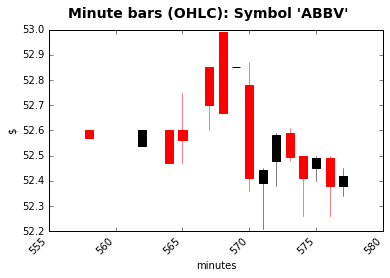

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2 = zip(*mb1.index.get_values())
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l2, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars (OHLC): Symbol \'ABBV\' ', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

# MVCC

How does the SciDB-Py library support MVCC

In [16]:
minute_bars.name

u'py1459869121036078015_00035'

# AsOf join

The `asof` operator joins trade data with quote data. At time points where quote data is not available, the last known value is looked up and filled in. This is sometimes also called a 'last value carry forward' join or 'piecewise constant interpolation join'.

The syntax is:
```
asof(A, B [, aggrDim [, missingCode]])
```

where the inputs are:
- `A & B`: two arrays that have the same dimensionality;
- `aggrDim`: the dimension in A along which to find last_value. Default is the last dimension.
- `missingCode`: the missing code to use, when an A record cannot be found. Default is 0.

Here is an example that joins trades and quotes for all symbols. 

Next we run the `asof` join and make some simple checks:

In [13]:
asof1 = quotes.asof(trades)
asof1 = asof1.eval()

In [14]:
print('\n# of elements in the joined result:')
print(asof1.nonempty())
print('\nThe head() of the joined array')
sdb.merge(asof1.project('ask_price', 'ask_size', 'bid_price', 'bid_size', 'price', 'volume'), tkr[tkr == 'ABBV']).\
    limit(20).\
    todataframe().tail()


# of elements in the joined result:
333421

The head() of the joined array


ask_price  ask_size  bid_price  bid_size  price  \
symbol_index tm                                                          
22           32378898      52.75         1      52.35         1  52.60   
             32428622      52.65         5      42.50         1  52.40   
             32441870      52.75         1      52.25         1  52.35   
             32859621      52.50         1      52.40        10  52.43   
             32885209      52.50         1      52.40        10  52.42   

                       volume symbol  
symbol_index tm                       
22           32378898     100   ABBV  
             32428622     100   ABBV  
             32441870     100   ABBV  
             32859621     100   ABBV  
             32885209     300   ABBV

# RegNMS (Compliance)

Smart analytics that can now be run:

 - Find the inconsistent quotes

In [15]:
sdb.merge(asof1.filter('ask_price < bid_price').\
          project('ask_price', 'ask_size', 'bid_price', 'bid_size', 'price', 'volume'), \
          tkr[tkr=='ABBV']).\
    limit(5).\
    todataframe()

ask_price  ask_size  bid_price  bid_size    price  \
symbol_index tm                                                            
22           34410408        0.0         0      52.51         2  52.5800   
             42275147        0.0         0      52.55         1  52.6000   
             43439844        0.0         0      52.70         2  52.7000   
             47035045        0.0         0      52.95         2  52.9599   
             50379525        0.0         0      53.15         3  53.1800   

                       volume symbol  
symbol_index tm                       
22           34410408     200   ABBV  
             42275147     100   ABBV  
             43439844     200   ABBV  
             47035045      50   ABBV  
             50379525      23   ABBV